# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import gzip
import pandas as pd
import numpy as np

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Los archivoz Json fueron extraídos previamente y guardados como CSV. Por lo tanto, la función de líneas arriba ya no fueron usadas para la presentación de este modelo

**Usuarios**

In [39]:
%%time
data_reviews = pd.read_csv('Data_descomprimida.csv')
data_reviews.drop(columns='Unnamed: 0', axis=1, inplace=True)
data_reviews.shape

Wall time: 3min 18s


(7793069, 12)

**Games**

In [5]:
%%time
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)
data_games.to_csv('Data_games.csv')
data_games.shape

Wall time: 2.74 s


(32135, 16)

In [4]:
%%time
data_games = pd.read_csv('Data_games.csv')
data_games.drop(columns='Unnamed: 0', axis=1, inplace=True)
data_games.shape

Wall time: 578 ms


(32135, 16)

## Exploración del Data Set
Empezaremos con la limpieza eliminando columnas que no aportan información relevante. 


#### 1. Limpiando la tabla de `data_reviews`
Este Data_frame contiene la información de todos los usuarios que hicieron la review del juego y la cantidad de horas jugadas

In [5]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
np.unique(le.fit_transform(data_reviews.compensation.astype(str)))

array([0, 1])

> La columna `compensation` solo tiene dos posibles valores: "Product received for free" y "NaN". Se procederá a eliminar

> La columna `user_id` no tiene todos los valores, usaremos solo los username para poder guiarnos.

> Las columnas `page_order` y `page` no nos da mucha información por ahora.

> La columna `text` tiene información valiosa escrita por los usuarios. Pero, para hacer un análisis de sentimientos deberiamos aplicar el PNL que tampoco se podría implementar porque el texto escrito contiene jergas de jugadores, emoticones y algunos están escritos en diferentes idiomas. Lo descartaremos... por ahora.

In [40]:
#Procedemos con la eliminación de las columnas
data_reviews.drop(columns= ['compensation', 'user_id', 'page', 'page_order','text','found_funny','early_access', 'products', 'date'], axis=1, inplace=True)

In [41]:
data_reviews.head()

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100
2,hello?<,14.6,328100
3,Cyderine916,5.0,35140
4,DarklyThinking,16.6,35140


Usaremos como estrategia la cantidad de horas que jugó el usuario para determinar si le gustó o no el juego. 
Entonces, buscaremos que todos usuarios de la review tengan las horas registradas, caso contrario los eliminaremos para poder trabajarlos.

In [8]:
array_deleted = data_reviews[data_reviews.hours.isna()].index #Buscamos los registros dónde los jugadores no contengan el valor de las horas jugadas.
data_reviews.drop(array_deleted, axis=0, inplace=True) #Procedemos a eliminarlos

In [42]:
print(f'Ahora, tenemos registros de: {data_reviews.shape[0]} jugadores con registro de las horas jugadas')

Ahora, tenemos registros de: 7793069 jugadores con registro de las horas jugadas


In [33]:
data_reviews[['username','product_id']].value_counts()[data_reviews[['username','product_id']].value_counts()>1]

username             product_id
123                  346110        549
                     252490         68
elitecase.net        306410         60
dpn2405              299460         60
...                  440            45
                                  ... 
BigPickle            360430          2
Ab ans Kletterseil!  440             2
AwryGuy              27000           2
BigPickleTickler     363600          2
Rankonius            386360          2
Length: 781881, dtype: int64

> El cuadro de arriba muestra los registros duplicados de los usuarios y productos_id. Tomaremos en cuenta el juego que registre la hora mayor jugada y el resto será eliminado.

In [44]:
%%time
id_max_horas = data_reviews.groupby(['username', 'product_id']).hours.transform(max)
data_reviews = data_reviews[data_reviews.hours == id_max_horas]
data_reviews.drop_duplicates(subset=['username','product_id'], inplace=True)

Wall time: 15.9 s


Comprobamos de que no existan duplicados para `data_revies`

In [46]:
data_reviews[['username','product_id']].value_counts()[data_reviews[['username','product_id']].value_counts()>1]

Series([], dtype: int64)

In [48]:
print(f'Existen {data_reviews.shape[0]} únicos para data_reviews')

Existen 6863842 únicos para data_reviews


Los jugadores que hayan registrado un total de 0 horas, no puede ser considerado para el algoritmo en busca de sus preferencias. Esto puede deberse que el juego no le gustó o en el momento de la recopilación del juego aún no lo había jugado. Pero, la información de lo que NO le ha gustado no es información valiosa para hacerle recomendaciones.

In [104]:
drop_aux = data_reviews[data_reviews.hours==0].index
data_reviews.drop(drop_aux, axis=0, inplace=True)

#### 2. Limpiando la tabla de `data_games`
Este data_frame contiene toda la información de los juegos. Hay algunas columnas que no usaremos por no ser información relevante

In [13]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


In [14]:
#Eliminamos las columnas que no usaremos
data_games.drop(columns= ['title', 'reviews_url','url','developer','tags', 'release_date', 'specs', 'early_access', 'sentiment', 'metascore','discount_price'], axis=1, inplace=True)

In [15]:
#Eliminaremos los juegos que no contengan un ID
data_games.drop(data_games.id[data_games.id.isna()].index, axis=0, inplace=True)

In [16]:
#Verificado el ID del juego que se duplica
data_games.id.value_counts()[data_games.id.value_counts()>1]

612880.0    2
Name: id, dtype: int64

In [17]:
data_games[data_games.id==612880]

,publisher,genres,app_name,discount_price,price,id
13894,Bethesda Softworks,['Action'],Wolfenstein II: The New Colossus,NaN,59.99,612880.0
14573,Bethesda Softworks,['Action'],Wolfenstein II: The New Colossus,NaN,59.99,612880.0


In [19]:
#Eliminaremos el único duplicado del data frame de los juegos
data_games.drop(13894, axis=0, inplace=True)

In [20]:
#Comprobamos que el dataframe contiene solo valores únicos respecto al juego
len(np.unique(data_games.id)), data_games.shape[0]

(32132, 32132)

Se espera que todos los juegos hayan sido calificados por los jugadores. Ahora, se buscará aquellos juegos que no tengan review y serán eliminados del data frame

In [21]:
Lista_id= list(np.unique(data_reviews.product_id)) 

In [22]:
len(np.unique(data_games.id[~data_games.id.isin(Lista_id)]))
#Esta cantidad representa a todos los juegos que no hayan sido valorados por nadie, entonces no las usaremos porque no sabemos si pudo haberle gustado a alquien

16742

In [23]:
array_deleted=data_games.id[~data_games.id.isin(Lista_id)].index
data_games.drop(array_deleted, axis=0, inplace=True)

In [43]:
print(f'Ahora, existen: {data_games.shape[0]} juegos que fueron calificados por los usuarios')

Ahora, existen: 15390 juegos que fueron calificados por los usuarios


#### Haremos un join entre data_games y data_reviews para ver valores estadísticos como máximo de horas jugadas, std de horas, etc

In [105]:
Lista_juegos= list(np.unique(data_reviews.product_id))

In [106]:
df_aux1 = data_reviews[['product_id']][data_reviews.product_id.isin(Lista_juegos)].value_counts().reset_index(name='Total_reviews')
aux_deleted = df_aux1[df_aux1.Total_reviews<25].index 
df_aux1.drop(aux_deleted, axis=0,inplace=True)

In [107]:
df_aux2 = data_reviews[data_reviews.product_id.isin(Lista_juegos)].groupby(['product_id']).agg({'hours': 'sum'}).reset_index().rename(columns={'hours':'Horas_jugadas_suma'})
df_aux3 = data_reviews[data_reviews.product_id.isin(Lista_juegos)].groupby(['product_id']).agg({'hours': 'mean'}).reset_index().rename(columns={'hours':'Horas_jugadas_promedio'})
df_aux4 = data_reviews[data_reviews.product_id.isin(Lista_juegos)].groupby(['product_id']).agg({'hours': 'std'}).reset_index().rename(columns={'hours':'Std_horas_jugadas'})
df_aux5 = data_reviews[data_reviews.product_id.isin(Lista_juegos)].groupby(['product_id']).agg({'hours': 'max'}).reset_index().rename(columns={'hours':'Max_horas_jugadas'})
df_aux6 = data_reviews[data_reviews.product_id.isin(Lista_juegos)].groupby(['product_id']).agg({'hours': 'min'}).reset_index().rename(columns={'hours':'Min_horas_jugadas'})

In [164]:
pt1 = pd.merge(df_aux1,df_aux2, on=['product_id'])[['product_id', 'Total_reviews','Horas_jugadas_suma']]
pt2 = pd.merge(df_aux3,df_aux4, on=['product_id'])[['product_id', 'Horas_jugadas_promedio','Std_horas_jugadas']]
pt3 = pd.merge(df_aux5,df_aux6, on=['product_id'])[['product_id', 'Max_horas_jugadas','Min_horas_jugadas']]
pt4 = pd.merge(pt1,pt2, on=['product_id'])[['product_id', 'Total_reviews','Horas_jugadas_suma','Horas_jugadas_promedio','Std_horas_jugadas']]

Calificaciones_byID = pd.merge(pt4,pt3, on=['product_id'])[['product_id', 'Total_reviews','Horas_jugadas_suma','Horas_jugadas_promedio','Std_horas_jugadas','Max_horas_jugadas','Min_horas_jugadas']]
Calificaciones_byID=pd.merge(Calificaciones_byID, data_games.rename(columns={'id':'product_id'}), on=['product_id'])[['product_id','app_name', 'price', 'Total_reviews','Horas_jugadas_suma','Horas_jugadas_promedio','Std_horas_jugadas','Max_horas_jugadas','Min_horas_jugadas']]


In [165]:
#Asignaremos un precio a los juegos Free
Calificaciones_byID[(Calificaciones_byID.price.isna()==False) & (Calificaciones_byID.price.str.contains("Free"))]=0

#existen algunos juegos que no son 'Free' y no se puede determinar su precio, se procede a eliminarse
aux_drop = Calificaciones_byID[(Calificaciones_byID.price.isna()==False) & (Calificaciones_byID.price.str.contains("[a-z]"))].index
Calificaciones_byID.drop(aux_drop, axis=0, inplace=True)

#También eliminaremos a los registros que no contengan un valor para el precio
Calificaciones_byID.dropna(subset=['price'], inplace=True)

#Procedemos a convertir price en un valor flotante para poder cálculos como: 'precio mayor', 'precio menor'
Calificaciones_byID['price']=Calificaciones_byID['price'].astype(float)

drop_aux= Calificaciones_byID[Calificaciones_byID.product_id==0].index
Calificaciones_byID.drop(drop_aux, axis=0, inplace=True)

In [166]:
Calificaciones_byID.sort_values(by="Min_horas_jugadas", ascending=False)

,product_id,app_name,price,Total_reviews,Horas_jugadas_suma,Horas_jugadas_promedio,Std_horas_jugadas,Max_horas_jugadas,Min_horas_jugadas
8048,643900,Alvora Tactics,9.99,29,750.9,25.893103,21.795772,108.7,5.5
5379,372940,Lost Lands: The Four Horsemen,6.99,80,1606.7,20.083750,30.048659,193.0,3.6
7648,504800,Sorcery! Part 4,9.99,33,908.6,27.533333,57.279821,321.9,3.5
4445,433000,Lost Lands: The Golden Curse,6.99,120,1941.1,16.175833,14.133487,119.9,3.4
8168,560720,Dark Angels: Masquerade of Shadows,3.99,28,147.3,5.260714,1.836329,10.6,3.2
...,...,...,...,...,...,...,...,...,...
2996,351090,Regency Solitaire,9.99,253,5103.0,20.169960,32.886284,291.1,0.1
2995,477870,Yomawari: Night Alone / 夜廻,19.99,253,2746.2,10.854545,14.903367,100.6,0.1
2994,1640,Disciples II: Gallean's Return,6.99,253,10001.8,39.532806,89.026388,1014.9,0.1
2993,390290,Bulb Boy,8.99,253,810.3,3.202767,2.283627,19.4,0.1


> Con el cuadro anterior se puede responder varias preguntas: ¿Cuál fue el juego más valorado?, ¿el menos valorado?, ¿el más caro?, ¿el más jugado?, ¿el menos jugado?

> Se agregaron columnas como la desviación estándar por cada juego, el min y máx de horas por cada juego. Se puede observar que esos valores son muy dispersos. Esto podría explicarse por la naturaleza de los jugadores, es decir: existen jugadores que compran  mucho y juegan un montón porque ya sea que tienen las posibilidades de comprarse cualquier juego que salga o porque tienen canales en las redes sociales y esto se compara con los jugadores promedios que pueden comprar un juego de vez en cuando y juegar lo usual para completar ciertas partida.

> También es importante destacar que algunos juegos no tienen final y por ello el contador de horas jugadas crecerá sin límites.



#### ¿Cuáles son los juegos con más reviews hechas por los usuarios? (top 10)

In [167]:
Calificaciones_byID.sort_values(by="Total_reviews", ascending=False).head(10).reset_index(drop=True)

,product_id,app_name,price,Total_reviews,Horas_jugadas_suma,Horas_jugadas_promedio,Std_horas_jugadas,Max_horas_jugadas,Min_horas_jugadas
0,252490,Rust,19.99,68029,30231292.1,444.388306,714.449402,18549.8,0.1
1,49520,Borderlands 2,19.99,50571,8509649.8,168.271337,281.342454,10296.4,0.1
2,377160,Fallout 4,29.99,48041,11005975.2,229.095464,329.506992,10031.2,0.1
3,271590,Grand Theft Auto V,39.99,41843,9155679.7,218.810308,297.801179,5918.8,0.1
4,391540,Undertale,9.99,40304,1295294.7,32.138118,64.690743,6567.5,0.1
5,221100,DayZ,34.99,39695,9691135.5,244.139955,431.749636,10879.2,0.1
6,620,Portal 2,19.99,38842,1713799.6,44.122331,182.487725,24176.7,0.1
7,4000,Garry's Mod,9.99,33660,18868569.8,560.563571,1004.034841,17993.9,0.1
8,346110,ARK: Survival Evolved,59.99,30558,15713131.9,514.206817,849.681242,12006.1,0.1
9,433850,H1Z1,19.99,30498,7306493.7,239.572880,408.988885,10144.2,0.1


> Cuadro que indica los juegos más relevantes, que contiene una cantidad considerabale de reviews hechas por los usuarios

#### ¿Y, cuáles son los juegos **más** jugados? (top 10)

In [168]:
Calificaciones_byID.sort_values(by="Horas_jugadas_suma", ascending=False).head(10).reset_index(drop=True)

,product_id,app_name,price,Total_reviews,Horas_jugadas_suma,Horas_jugadas_promedio,Std_horas_jugadas,Max_horas_jugadas,Min_horas_jugadas
0,252490,Rust,19.99,68029,30231292.1,444.388306,714.449402,18549.8,0.1
1,4000,Garry's Mod,9.99,33660,18868569.8,560.563571,1004.034841,17993.9,0.1
2,107410,Arma 3,39.99,28865,18328683.8,634.979518,957.802607,19301.1,0.1
3,346110,ARK: Survival Evolved,59.99,30558,15713131.9,514.206817,849.681242,12006.1,0.1
4,377160,Fallout 4,29.99,48041,11005975.2,229.095464,329.506992,10031.2,0.1
5,48700,Mount & Blade: Warband,19.99,25653,10376963.9,404.512685,631.183613,18720.5,0.1
6,240,Counter-Strike: Source,19.99,20966,10075214.4,480.550148,1070.861394,26928.8,0.1
7,221100,DayZ,34.99,39695,9691135.5,244.139955,431.749636,10879.2,0.1
8,271590,Grand Theft Auto V,39.99,41843,9155679.7,218.810308,297.801179,5918.8,0.1
9,49520,Borderlands 2,19.99,50571,8509649.8,168.271337,281.342454,10296.4,0.1


> Cuadro que indica cuáles son los juegos con horjas más jugadas, coincide con el top de revies hecha. Esto se explica porque si un juego es jugado por mucho tiempo generaría más reseñas describiendo la experiencia.

### ¿Y cuáles son los jugadores qué más reviews hacen? (top 10)

In [219]:
%%time
data_aux_reviews = data_reviews.username.value_counts().to_frame().rename(columns={'username':'Reviews_hechas'})
data_aux_reviews.head(10)

Wall time: 4.02 s


,Reviews_hechas
Saint Aaron,1235
Kodyd194,1100
VahidSlayerOfAll,885
Alex,869
Nick,861
Chris,805
Tom,805
Salarn,774
..,731
Sarkoth,730


> Cuadro que muestra a todos los jugadores con más reviews hechas. Estos usuarios podrían los que poseen más actividad en las redes sociales para demostrar y explotar la mayoría de juegos jugados.

### ¿Y cuáles son los juegos más costosos? (top 10)

In [217]:
Calificaciones_byID.sort_values(by="price", ascending=False).head(10).reset_index(drop=True)

,product_id,app_name,price,Total_reviews,Horas_jugadas_suma,Horas_jugadas_promedio,Std_horas_jugadas,Max_horas_jugadas,Min_horas_jugadas
0,292180,X-Plane 10 Global - 64 Bit,771.71,582,94935.8,163.119931,373.105816,3933.9,0.2
1,401090,MODO indie 10,299.99,54,25353.7,469.512963,733.938784,2685.8,1.8
2,442120,Pinball FX3,202.76,264,6457.9,24.461742,71.137007,913.9,0.1
3,528200,VEGAS Pro 14 Edit Steam Edition,199.00,268,22319.2,83.280597,181.777979,1510.8,0.1
4,285580,ACE - Arena: Cyber Evolution,189.96,674,17111.0,25.387240,147.034109,2631.4,0.1
5,211500,RaceRoom Racing Experience,160.91,3065,148726.5,48.524144,179.708856,4717.2,0.1
6,342570,HIS (Heroes In the Sky),139.92,276,16698.9,60.503261,392.721630,4232.1,0.1
7,248170,Clickteam Fusion 2.5,99.99,330,198251.5,600.762121,1322.932666,11957.5,0.1
8,100980,3D-Coat V4.8,99.99,40,6772.4,169.310000,529.308035,3286.0,0.3
9,253670,Aartform Curvy 3D 3.0,99.99,34,1875.0,55.147059,139.321743,733.3,0.2


> El juego más caro no tiene muchas reviews, esto se explica a que pocos usuarios la pudieron comprar y por tanto no pudieron hacer su review.

### Estudiaremos algunas correlaciones entre las variables de la tabla de resumen estádistico.

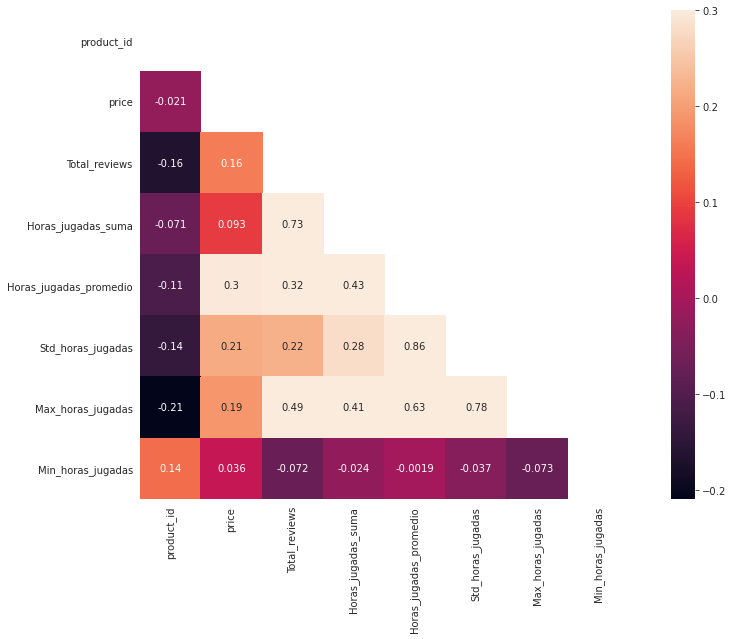

In [237]:
corr =  Calificaciones_byID.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

> Exsite una correlación positiva muy fuerte entre `horas_jugadas` con `Total_reviews`. Esto se explica porque mientras más tiempo sea jugado un juego más reviews generará para detallar la experiencia del usuario con el juego.

In [218]:
Calificaciones_byID.corr()

,product_id,price,Total_reviews,Horas_jugadas_suma,Horas_jugadas_promedio,Std_horas_jugadas,Max_horas_jugadas,Min_horas_jugadas
product_id,1.000000,-0.021151,-0.164292,-0.070964,-0.109345,-0.138785,-0.209575,0.143546
price,-0.021151,1.000000,0.161864,0.092699,0.296131,0.214482,0.190454,0.035913
Total_reviews,-0.164292,0.161864,1.000000,0.730588,0.320023,0.223566,0.491946,-0.072004
Horas_jugadas_suma,-0.070964,0.092699,0.730588,1.000000,0.426392,0.280211,0.408927,-0.024282
Horas_jugadas_promedio,-0.109345,0.296131,0.320023,0.426392,1.000000,0.857324,0.628780,-0.001917
Std_horas_jugadas,-0.138785,0.214482,0.223566,0.280211,0.857324,1.000000,0.778485,-0.036801
Max_horas_jugadas,-0.209575,0.190454,0.491946,0.408927,0.628780,0.778485,1.000000,-0.073178
Min_horas_jugadas,0.143546,0.035913,-0.072004,-0.024282,-0.001917,-0.036801,-0.073178,1.000000


### Estuadiamos la distribución de la varibale `hours` del dataset `data_reviews`

In [280]:
round(data_reviews.hours.describe(),2)

count    6859674.00
mean         101.08
std          373.82
min            0.10
25%            3.60
50%           13.70
75%           52.20
max        42100.70
Name: hours, dtype: float64

In [342]:
for i in np.arange(5, 35,step=5):
    print(f'Existen: {data_reviews.hours[data_reviews.hours>=i].shape[0]}  jugadores con al menos {i} horas jugadas')

Existen: 4789655  jugadores con al menos 5 horas jugadas
Existen: 3897470  jugadores con al menos 10 horas jugadas
Existen: 3307299  jugadores con al menos 15 horas jugadas
Existen: 2897677  jugadores con al menos 20 horas jugadas
Existen: 2594773  jugadores con al menos 25 horas jugadas
Existen: 2357912  jugadores con al menos 30 horas jugadas


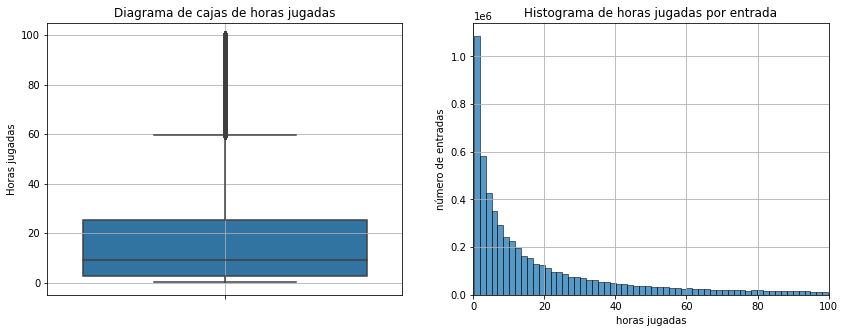

In [272]:
max_hour=100
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
sns.boxplot(y=data_reviews.hours[data_reviews.hours<max_hour])
plt.title("Diagrama de cajas de horas jugadas")
plt.grid()
plt.ylabel('Horas jugadas')
plt.subplot(1,2,2)
sns.histplot(data = data_reviews.hours[data_reviews.hours<max_hour], bins = 60)
plt.title("Histograma de horas jugadas por entrada")
plt.xlabel("horas jugadas")
plt.ylabel("número de entradas")
plt.xlim(0,max_hour)
plt.grid()
plt.show()

> En el gráfico de la izquierda se muestra una digrama de caja con las horas jugadas, la mayoría de datos se concentran en los tres primeros cuartiles (hasta el 75%). Después del tercer cuartil los valores se ven disparados por jugadores más veteranos que acumulan horas de hasta 42,000 horas.

### Estuadiamos la distribución de la varibale `product_id` del dataset `data_games`

In [292]:
print(f'Existen: {data_games.shape[0]} juegos únicos')

Existen: 15390 juegos únicos


In [345]:
#Imprimimos un DataFrame de la cantidad de jugadores por ID
games_por_usuario= data_reviews.product_id.value_counts().to_frame().reset_index().rename(columns={'index':'id_game', 'product_id':'cantidad_de_jugadores'})
games_por_usuario

,id_game,cantidad_de_jugadores
0,440,121319
1,252490,68029
2,49520,50571
3,377160,48041
4,301520,45607
...,...,...
15375,619380,1
15376,381152,1
15377,666080,1
15378,391190,1


In [347]:
for i in np.arange(5, 35,step=5):
    suma = np.sum(data_reviews.product_id.value_counts().values[games_por_usuario.cantidad_de_jugadores >= i])
    print(f'Existen: {games_por_usuario.cantidad_de_jugadores[games_por_usuario.cantidad_de_jugadores>=i].shape[0]} juegos con al menos {i} jugadores y con {suma} reviews')


Existen: 13002 juegos con al menos 5 jugadores y con 6854158 reviews
Existen: 11286 juegos con al menos 10 jugadores y con 6842594 reviews
Existen: 10116 juegos con al menos 15 jugadores y con 6828701 reviews
Existen: 9241 juegos con al menos 20 jugadores y con 6813961 reviews
Existen: 8551 juegos con al menos 25 jugadores y con 6798782 reviews
Existen: 7972 juegos con al menos 30 jugadores y con 6783176 reviews


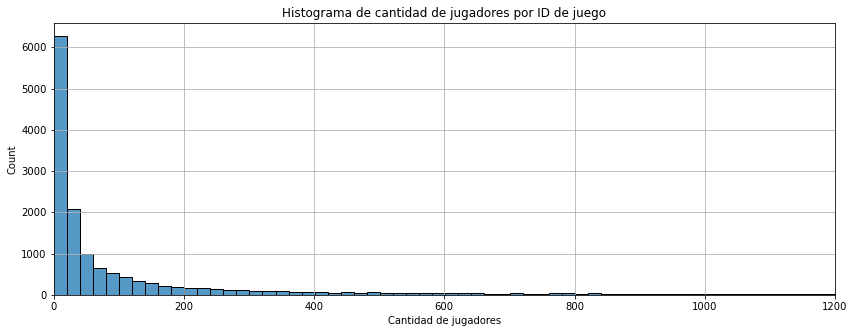

In [354]:
plt.figure(figsize=(14,5))
sns.histplot(games_por_usuario.cantidad_de_jugadores[games_por_usuario.cantidad_de_jugadores<=1200], bins=60)
plt.title('Histograma de cantidad de jugadores por ID de juego')
plt.xlabel('Cantidad de jugadores')
plt.xlim(0,1200)
plt.grid()

### Estudiaremos la distribución de `genres` del data_set `data_games`

In [94]:
lista_generos=[]
array_generos=np.array(data_games.dropna(subset=['genres']).genres)
for i in range(0, len(array_generos)):
    array_generos[i]=array_generos[i].replace(" ", "")
    array_generos[i]=array_generos[i].replace("'", "")
    array_generos[i]=array_generos[i].replace("[", "")
    array_generos[i]=array_generos[i].replace("]", "")
    aux = array_generos[i].split(",")
    lista_generos.append(aux)


In [96]:
lista_generos=[item 
           for sublist in lista_generos
           for item in sublist]

In [99]:
index_generos = list(np.unique(lista_generos))
values_generos = [lista_generos.count(item) for item in index_generos]

distribucion_generos = pd.Series(values_generos, index = index_generos) 
distribucion_generos.sort_values(ascending=False)

Indie                      9979
Action                     6536
Adventure                  5279
Casual                     4760
Strategy                   3215
RPG                        2516
Simulation                 2372
EarlyAccess                1344
FreetoPlay                  855
Sports                      576
Racing                      559
MassivelyMultiplayer        431
Utilities                   150
Design&amp;Illustration     121
Animation&amp;Modeling       86
VideoProduction              65
Education                    63
SoftwareTraining             49
AudioProduction              46
PhotoEditing                 33
WebPublishing                30
Accounting                    3
dtype: int64

#### Generación del rating 

Trabajaremos en el feedback implícito para aprender las preferencias del usuario, específicamente, usando el tiempo de juego como nuestra medida indirecta. Después de un análisis propusimos un límite de 5 horas como suficiente para diferenciar entre preferencia o no. De hecho, esta es una suposición fuerte, ya que lo ideal sería conocer el tiempo de juego habitual de cada juego como una medida más precisa. Pero en aras de la simplicidad, dejamos esta idea para trabajos futuros.

In [34]:
data_reviews= data_reviews[data_reviews.hours>=5]
data_reviews['Ratings']=1
data_reviews.reset_index(drop=True, inplace=True)
data_reviews.shape

<ipython-input-34-e543fdc44ac5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews['Ratings']=1


(2284310, 6)

#### Eliminación de juegos poco populares

Para obtener un dataset limpio, primero vamos a eliminar aquellos juegos que cuentan con menos de 25 usuarios, ya que no son los suficientemente populares para desarrollar un sistema de recomendación.

In [124]:
lista_juegos = list(data_reviews.product_id.value_counts()[data_reviews.product_id.value_counts()>=25].index)
data_reviews = data_reviews[data_reviews.product_id.isin(lista_juegos)]
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(4740008, 4)

#### Eliminación de jugadores con pocos juegos

Ahora vamos a eliminar aquellos usuarios que tienen menos de 5 juegos, ya que no cuentan con juegos suficientes para desarrollar un algoritmo robusto que permita hacer recomendaciones adecuadas.

In [16]:
listausuarios = list(data_reviews.username.value_counts().index[data_reviews.username.value_counts().values >= 5])
data_reviews = data_reviews[data_reviews.username.isin(listausuarios)]
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(3469804, 3)

#### generación de un número de identificación para los usuarios

In [18]:
usernames = list(np.unique(data_reviews.username))
user_encooded = np.arange(0,len(usernames))
data_reviews['user_id'] = data_reviews.username.map(dict(zip(usernames,user_encooded)))

#### generación de un número de identificación continuo para los juegos

In [19]:
games = list(np.unique(data_reviews.product_id))
game_encooded = np.arange(0,len(games))
data_reviews['game_id'] = data_reviews.product_id.map(dict(zip(games,game_encooded)))
data_games = data_games[data_games.id.isin(games)]
data_games = data_games.reset_index(drop = True)
data_games['game_id'] = data_games.id.map(dict(zip(games,game_encooded)))

In [29]:
data_reviews

,username,hours,product_id,user_id,game_id
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,273604,4238
1,DarklyThinking,16.6,35140,45988,742
2,Teef 🐏,0.9,725280,183938,14457
3,nd,1.0,725280,249563,14457
4,Sneaky_Panda,0.6,725280,172210,14457
...,...,...,...,...,...
3469799,dab,161.8,252490,227460,2208
3469800,Prime,314.6,252490,145706,2208
3469801,Zezztah,591.3,252490,212475,2208
3469802,Kero,198.5,252490,98972,2208


### Guardamos nuestro data_set

In [36]:
%%time
#Guardaremos los data sets ya filtrados
data_games.to_csv('Data_filtrada\data_games_filtrada.csv')
data_reviews.to_csv('Data_filtrada\data_reviews_filtrada.csv')
Calificaciones_byID.to_csv('Data_filtrada\Calificaciones_byID.csv')

Wall time: 7.42 s


In [2]:
%%time
data_games=pd.read_csv('Data_filtrada\data_games_filtrada.csv').drop(columns='Unnamed: 0', axis=1)
data_reviews=pd.read_csv('Data_filtrada\data_reviews_filtrada.csv').drop(columns='Unnamed: 0', axis=1)
Calificaciones_byID=pd.read_csv('Data_filtrada\Calificaciones_byID.csv').drop(columns='Unnamed: 0', axis=1)

Wall time: 2.81 s


# Método: modelos de sistemas de recomendación
* ## Alternating Least Squares (ALS) (Mínimos cuadrados alternantes (ALS))

Bajo la diversidad de modelos de factorización matricial, el modelo ALS se destaca por ser capaz de funcionar utilizando retroalimentación implícita. Este es un modelo de factores latentes, al igual que SVD. [Artículo: Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)

También utilizaremos la librería [Implicit](https://implicit.readthedocs.io/en/latest/), que se especializa en el manejo de Datasets de feedback implicito.

* ## Preliminares y formulación del modelo:
Nos reservamos letras de indexación especiales para distinguir a los usuarios de los elementos: para los usuarios: $u$, $v$, y para los elementos: $i$, $j$. Los datos de entrada asocian usuarios y elementos a través de valores $r_{ui}$, que de ahora en adelante llamaremos **observaciones**.

Primero, necesitamos formalizar la noción de confianza que miden las variables $r_{ui}$. Para ello, introduzcamos un conjunto de variables binarias $p_{ui}$, que indican la preferencia del usuario $u$ por el ítem $i$. Los valores de $p_{ui}$ se derivan binarizando los valores de $r_{ui}$:
$$p_{ui}=\begin{cases} 1& \ r_{ui} 	\geq 5\\ 0& \ r_{ui} < 5 \end{cases}$$


En otras palabras, si un usuario $u$ jugó un juego $i$ al menos unas cinco horas  ($r_{ui}>= 5$), entonces tenemos una indicación de que a $u$ le gusta el juego $i$ ($p_{ui}$ = 1). Por otro lado, si $u$  jugó menos de ese tiempo el  juego $i$, no creemos que haya ninguna preferencia ($p_{ui}$ = 0). $p_{ui}$ se calcula desarrollando el producto vectorial de la siguiente manera: $$p_{ui} = x_{u}^{T}y_{i}$$

En general, a medida de que crece $r_{ui}$ tenemos una indicación más fuerte de qué le gusta al usuario $u$. Ahora, se introduce una conjunto de variables $C_{ui}$ que mide la confianza observada de $P_{ui}$: $$C_{ui} = \alpha p_{ui}$$

> De esta manera, se mide la confianza en $P_{ui}$ para cada par de user-ítem, pero a medida que se observa más evidencia de preferecnia positiva nuestra confianza en $P_{ui}$ aumenta en consecuencia. La tasa de aumento está controlada por $\alpha$, siendo este un hiperparámetro. Donde $\alpha$ es un factor de escala lineal que otorga más importancia a los elementos relevantes, por encima de los que nunca se han jugado. Bajo estas definiciones, la búsqueda de factor latente para usuarios y juegos se realiza mediante la optimización de la siguiente función de costo:


>> $${min}_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x_{u}^{T}y_{i})^{2} + \lambda \bigg(\sum_{u} \|x_{u}\|^{2} + \sum_{i} \|y_{i}\|^{2}\bigg)$$

> $\lambda$ es necesario para regularizar el modelo de tal manera que no se sobreajuste. La minimización de esta función se desarrolla con el método de gradiente conjugado.[1]

>[ [1]  Applications of the Conjugate Gradient Method for Implicit
Feedback Collaborative Filtering
](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.379.6473&rep=rep1&type=pdf)

* ## Elección de la métrica de evaluación

Usaremos MAP cómo métrica de evaluación. Nos basamos en el siguiente [artículo](https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)
> * MAP : Precisión media media


> Digamos que tenemos un conjunto de datos de relevancia binaria (que es nuestro caso). Queremos evaluar la lista completa de elementos recomendados hasta un límite N específico. Esta métrica le da más peso a los errores en la lista de recomendaciones. El objetivo es eliminar el error en los primeros elementos en lugar de mucho más tarde en la lista. Para ello, necesitamos una métrica que pondera los errores en consecuencia. El objetivo es ponderar mucho los errores en la parte superior de la lista. Luego, disminuya gradualmente la importancia de los errores a medida que bajamos los elementos inferiores de una lista.

> La métrica de predicción promedio (AP) intenta aproximarse a esta escala móvil de ponderación. Utiliza una combinación de la precisión en las sublistas sucesivas, combinada con el cambio de recuerdo en estas sublistas. El cálculo es el siguiente:

> 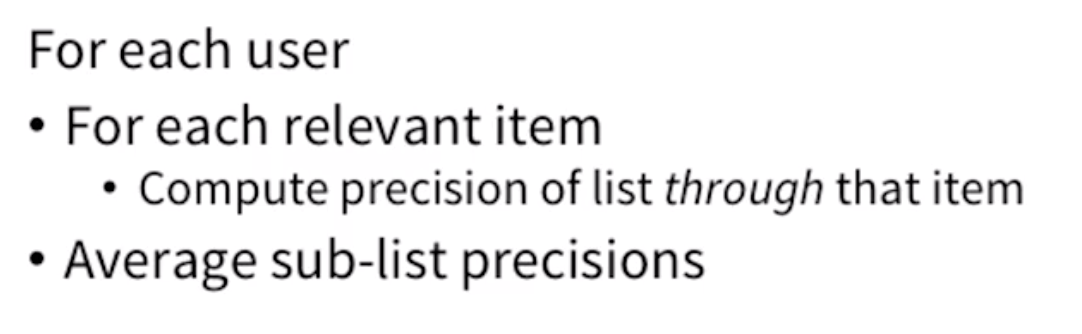



> 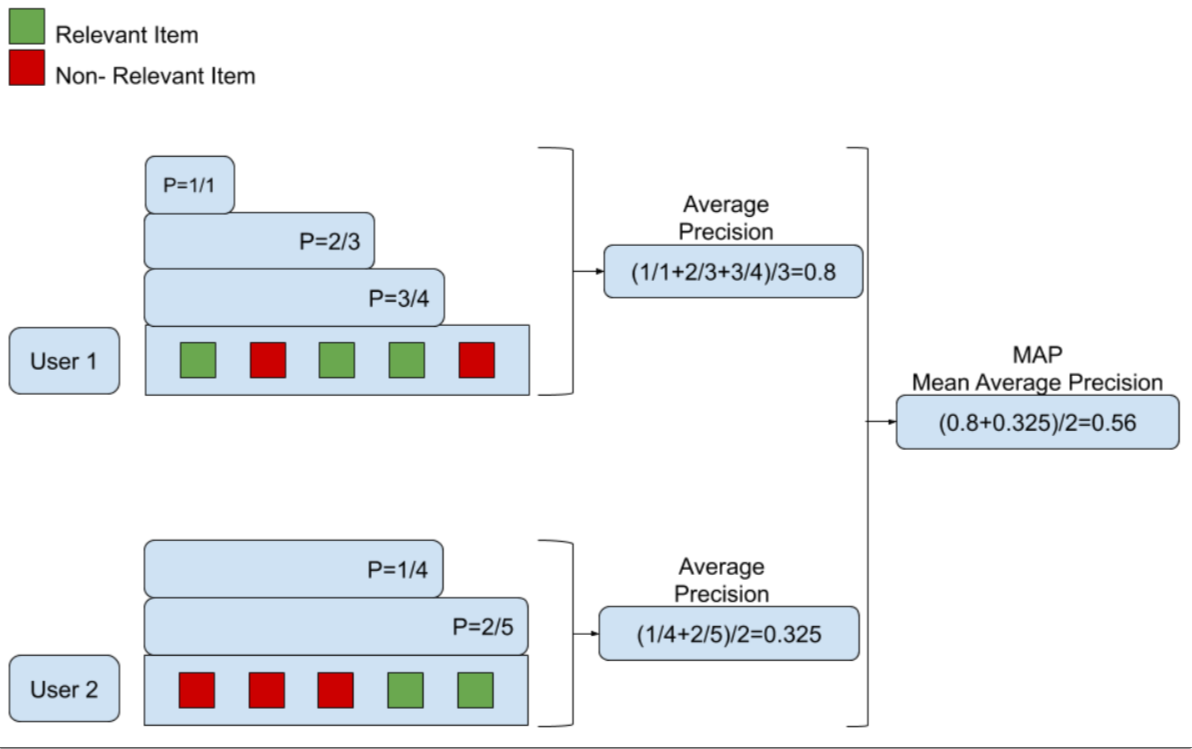

>> En la figura anterior, vemos que la métrica de Precisión promedio está en la lista de recomendación única, es decir, a nivel de usuario. Calcular la precisión a través de este elemento significa subdividir la lista de recomendaciones. Examinamos una nueva sublista cada vez que obtenemos un elemento relevante. Luego calculamos la precisión en esta sublista actual. Hacemos esto para cada sublista hasta que llegamos al final de nuestras recomendaciones. Ahora que tenemos un conjunto de precisiones, las promediamos para obtener la precisión promedio para un solo usuario. Luego obtenemos el AP para todos los usuarios y obtenemos la precisión promedio promedio.

>> Es importante definir la precisión:

$$ P = \frac{\text{número de items relevantes en la lista}}{\text{número de items en la lista}}$$

>> Y, la relevancia se define como la siguiente función por tramos

$$relevancia = \begin{cases} 1& \ \text{si el item es relevante (en nuestro caso si jugó o no)} \\ 0& \ \text{si el item no es relevante (que no lo jugó)} \end{cases}$$

>> Con estas dos se define para cada usuario la precisión media a $K$ items como la sumatoria de las precisiones de los elementos relevantes en $K$ sobre el número total de elementos relevantes en $K$

$$ AveP@K = \displaystyle \frac{\sum_{k=1}^{K} P(k) \times relevancia(k)}{\text{número de items relevantes}} $$

>> Finalmente para obtener un valor para el conjunto completo de usuarios se define la presición media promedio a $K$ items como el promedio de las precisiones medias a $K$ items para cada usuario $u$

$$ MAP@K = \displaystyle \frac{\sum_{u=1}^{U} AveP(u)}{N} $$

A partir del dataset Reviews generamos una matriz de utilidad, que tomará los valores de calificación de un usuario por un juego (1 o 0) y los albergará en una matriz con dimensiones (# juegos, # usuarios). Esta matriz está en formato CSR (compressed sparse row matrix). A partir de ella se genera otra matriz con dimensiones (# usuarios, # juegos) que es la transpuesta de la primera matriz.

La primera matriz será usada para entrenar el modelo y la segunda matriz será usada para generar las recomendaciones a partir del modelo entrenado.

#### Para desarrollar el modelo de mínimos cuadraddos alternantes se necesitará desarrollar una matriz de utilidad, esta misma contendrá los valores de las califiaciones de los jugadores $u$ por un juego $i$, siendo en este caso un 0 o 1. La matriz de utilidad tendrá la dimensión $M_{juegos x jugadores}$.

In [3]:
import os
from scipy import sparse
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, ranking_metrics_at_k
os.environ['MKL_NUM_THREADS'] = '1' #Por recomendación WARNING:root:Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading

In [4]:
data = data_reviews[['game_id','user_id','Ratings']]

In [5]:
matrix_item_user = sparse.csr_matrix((data['Ratings'].astype(int), (data['game_id'], data['user_id'])))
matrix_user_item = matrix_item_user.transpose()
matrix_item_user.shape

(14963, 280212)

Iniciaremos $\alpha=40$, más adelante buscaremos un mejor valor

In [6]:
alpha = 40

#Realizamos nuestro train_test_split con un 70% valor de entrenamiendo
train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.7)
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15, random_state=42)

In [7]:
%%time
model.fit(train, show_progress=True)


Wall time: 11.6 s


In [8]:
%%time
p_K = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=True)
print('el modelo tiene un valor de MAP@k igual a : %0.3f' % (p_K['map']))


el modelo tiene un valor de MAP@k igual a : 0.046
Wall time: 1min 16s


### Benchmark

In [9]:
rank = data.game_id.value_counts().index
#Rank muestra todos los juegos y su cantidad de valoraciones que tuvo

score = np.linspace(1.9,-20,len(rank))
recomendations = list(tuple(zip(rank, score)))

In [19]:
class Benchmark_popularidad:
    
    def __init__(self, recomendations):
        self.recomendations = recomendations
        
    def recommend(self, userid, user_item, N):
        recomendations = self.recomendations[:N]
        return recomendations

In [20]:
Benchmark = Benchmark_popularidad(recomendations)

In [24]:
%%time
p_K_benchmark = ranking_metrics_at_k(Benchmark, train.T.tocsr(), test.T.tocsr(), K=20, show_progress=True)
# print('el modelo benchmark tiene un valor de MAP@k igual a : %0.3f' % (p_K_benchmark['map']))
print(f"El modelo de Benchmark tiene un valor de MAP@K : {round((p_K_benchmark['map']),3)}")


El modelo de Benchmark tiene un valor de MAP@K : 0.037
Wall time: 808 ms


### Optimización de hiperpametros

In [25]:
%%time
alphas = [x for x in range(10,61,2)]
metrics_alphas = []

for alpha in alphas:
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_alphas.append(r)

Wall time: 26min 35s


In [26]:
%%time
factors = [x for x in range(10,61,2)]
metrics_factors = []

for factor in factors:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=factor, regularization=0.1, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_factors.append(r)

Wall time: 26min 20s


In [27]:
%%time
regs = [x for x in range(20,71,2)]
metrics_regs = []

for reg in regs:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=reg, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_regs.append(r)

Wall time: 24min 1s


In [28]:
%%time
iterations = [x for x in range(15,101,5)]
metrics_iterations = []

for iteration in iterations:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=iteration, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_iterations.append(r)

Wall time: 27min 49s


In [29]:
%%time
map_alpha = []
map_factor = []
map_reg = []
map_iteration = []

for i in range(len(metrics_alphas)):
    map_alpha.append(metrics_alphas[i]['map'])
    
for i in range(len(metrics_factors)):
    map_factor.append(metrics_factors[i]['map'])
    
for i in range(len(metrics_regs)):
    map_reg.append(metrics_regs[i]['map'])
    
for i in range(len(metrics_iterations)):
    map_iteration.append(metrics_iterations[i]['map'])

Wall time: 0 ns


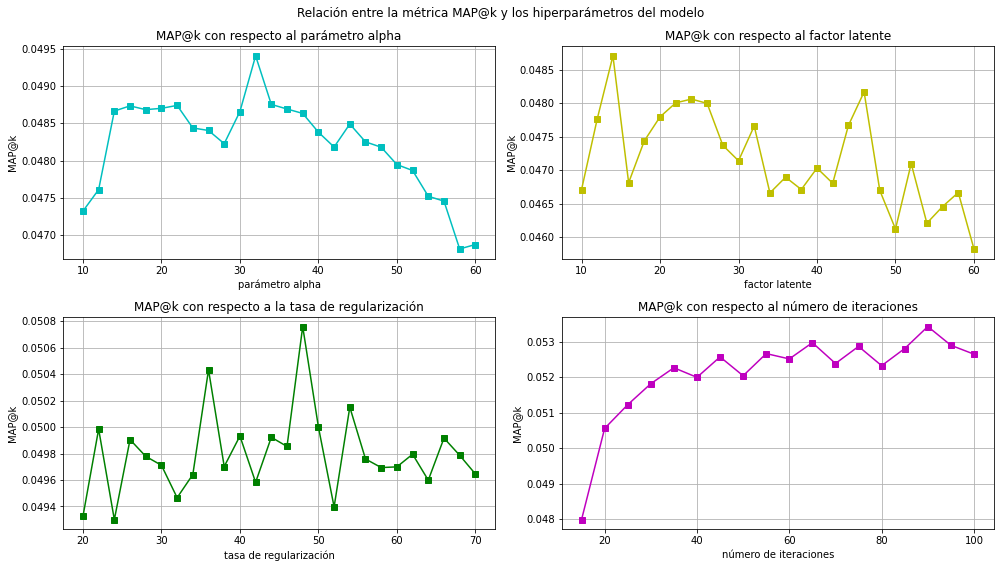

In [167]:
plt.figure(figsize=(14,8))
plt.suptitle('Relación entre la métrica MAP@k y los hiperparámetros del modelo')
plt.subplot(2,2,1)
plt.title('MAP@k con respecto al parámetro alpha')
plt.plot(alphas, map_alpha, 's-c')
plt.xlabel('parámetro alpha')
plt.ylabel('MAP@k')
# plt.xlim(10,60)
plt.grid()
plt.subplot(2,2,2)
plt.title('MAP@k con respecto al factor latente')
plt.plot(factors, map_factor, 's-y')
plt.xlabel('factor latente')
plt.ylabel('MAP@k')
# plt.xlim(10,40)
plt.grid()
plt.subplot(2,2,3)
plt.title('MAP@k con respecto a la tasa de regularización')
plt.plot(regs, map_reg, 's-g')
plt.xlabel('tasa de regularización')
plt.ylabel('MAP@k')
# plt.xlim(20,70)
plt.grid()
plt.subplot(2,2,4)
plt.title('MAP@k con respecto al número de iteraciones')
plt.plot(iterations, map_iteration, 's-m')
plt.xlabel('número de iteraciones')
plt.ylabel('MAP@k')
# plt.xlim(15,100)
plt.grid()
plt.tight_layout()
plt.show()

> Vemos que la métrica aumenta conforme al número de iteraciones hasta que llega aproximadamente a 55 iteraciones y luego se mantiene constante, por ello tomaremos este valor. Los otros tres hiperparámetros presentan un valor máximo que determinaremos por validación cruzada en un conjunto de valores mucho mas cerrado que los rangos evaluados incialmente.

In [178]:
[x for x in range(50,57,2)]
    

[50, 52, 54, 56]

In [183]:
%%time
alphas2 = [x for x in range(30,31,2)]
factors2 = [x for x in range(70,95,5)]
regs2 = [x for x in range(50,57,2)]

metrics_grid = []
alphas_grid = []
factors_grid = []
regs_grid = []

for alpha in alphas2:
    for factor in factors2:
        for reg in regs2:
            train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
            model = AlternatingLeastSquares(factors=factor, regularization=reg, iterations=90, random_state=42)
            model.fit(train, show_progress=False)
            r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
            metrics_grid.append(r)
            alphas_grid.append(alpha)
            factors_grid.append(factor)
            regs_grid.append(reg)

Wall time: 1h 2min 53s


In [187]:
map_grid = []

for i in range(len(metrics_grid)):
    map_grid.append(metrics_grid[i]['map'])

In [188]:
dict_metrics = {'alpha': alphas_grid, 'factor': factors_grid, 'regularization': regs_grid, 'MAP_k': map_grid}
Frame_metrics = pd.DataFrame(data=dict_metrics)

In [34]:
Frame_metrics[Frame_metrics.MAP_k == Frame_metrics.MAP_k.max()]

,alpha,factor,regularization,MAP_k
364,30,50,55,0.054701


In [189]:
Frame_metrics[Frame_metrics.MAP_k == Frame_metrics.MAP_k.max()]

,alpha,factor,regularization,MAP_k
1,30,70,52,0.054788


Arriba vemos los hiperparámetros obtenidos, para el desempeño de la métrica de evaluación. A continuación instanciaremos el modelo nuevamente con estas hiperparámetros y desarrollaremos las predicciones

#### Evaluación del modelo y presentación de resultados

In [35]:
alpha = 30
train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
model = AlternatingLeastSquares(factors=50, regularization=55, iterations=55, random_state=42)
model.fit(train, show_progress=True)

In [36]:
p_K = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=True)
print('el modelo tiene un valor de MAP@k igual a : %0.3f' % (p_K['map']))


el modelo tiene un valor de MAP@k igual a : 0.054


In [37]:
#Evaluemos como varia la métrica MAP@k respecto al valor de K, tanto para el modelo optimizado como para el caso Benchmark
%%time
Ks = [5,10,20,30,50,80,100,150,200,250,300,350,400,450,500]

metrics_model = []
metrics_Benchmark = []

for K in Ks:
    r_model = ranking_metrics_at_k(model, train.T, test.T, K=K, show_progress=False)
    r_benchmark = ranking_metrics_at_k(Benchmark, train.T, test.T, K=K, show_progress=False)
    metrics_model.append(r_model)
    metrics_Benchmark.append(r_benchmark)   

In [38]:
precision_model = []
precision_benchmark = []

for i in range(len(metrics_model)):
    precision_model.append(metrics_model[i]['map'])
    precision_benchmark.append(metrics_Benchmark[i]['map'])

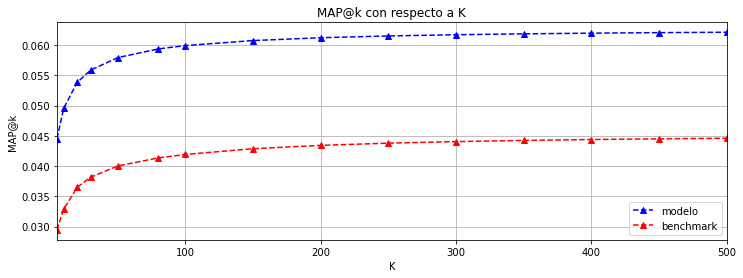

In [160]:
plt.figure(figsize=(12,4))
plt.title('MAP@k con respecto a K')
plt.plot(Ks, precision_model, '^--b', label='modelo')
plt.plot(Ks, precision_benchmark, '^--r', label='benchmark')
plt.xlabel('K')
plt.ylabel('MAP@k')
plt.legend(loc=0)
plt.xlim(5,500)
plt.grid()
plt.show()

Vemos que los resultados del modelo son consistentemente mejores que la linea base

Ahora realizaremos las predicciones para un usuario aleatorio

In [144]:
n_random = int(np.random.randint(0,data_reviews.shape[0],1))
user = data_reviews.user_id.loc[n_random]

In [145]:

usuario = np.unique(data_reviews.username[data_reviews.user_id == user])[0]
juegos_usuario_codigo = data_reviews.game_id[data_reviews.user_id == user]
juegos_usuario = list(juegos_usuario_codigo.map(dict(zip(data_games.game_id,data_games.app_name))).values)

In [146]:
recommended = model.recommend(userid = user, user_items = matrix_user_item, N=20, filter_items = list(juegos_usuario_codigo))

In [147]:
games = []
preds = []
for i in range(0,len(recommended)):
    game = recommended[i][0]
    pred = recommended[i][1]
    games.append(game)
    preds.append(pred)
    
recom = pd.Series(preds, index = games)
recom.index = recom.index.map(dict(zip(data_games.game_id,data_games.app_name)))

In [148]:
print('Usuario : ', usuario)
print('Juegos del Usuario : ', juegos_usuario)

Usuario :  CptCobbler
Juegos del Usuario :  ['Zombie Shooter', 'Automation - The Car Company Tycoon Game', 'BeamNG.drive', 'FlatOut 2™', 'Banished', 'FlatOut', 'Turmoil', 'Basement', 'Software Inc.']


In [149]:
print('Recomendaciones por similitud: \n')
print(recom)

Recomendaciones por similitud: 

Prison Architect                               1.053739
American Truck Simulator                       0.745966
Factorio                                       0.726104
Cities: Skylines                               0.715115
SPINTIRES™                                     0.714434
Euro Truck Simulator 2                         0.680936
Farming Simulator 15                           0.640760
Kerbal Space Program                           0.628063
Train Simulator                                0.627468
Game Dev Tycoon                                0.577306
Farming Simulator 17                           0.541380
Youtubers Life                                 0.506733
Stranded Deep                                  0.498153
Mini Metro                                     0.494076
Planetbase                                     0.483155
Microsoft Flight Simulator X: Steam Edition    0.474479
Tropico 5                                      0.460258
Plague Inc: Evo

Explicación del principal juego recomendado

In [150]:
idx_recom = 0
top_recomendado = data_games.game_id[data_games.app_name == recom.index[idx_recom]].values[0]
explicacion = model.explain(userid = user, user_items = matrix_user_item * alpha, itemid = top_recomendado, N=10)

In [151]:
score_top = explicacion[0]

games = []
scores = []
for i in range(0,len(explicacion[1])):
    game = explicacion[1][i][0]
    score = explicacion[1][i][1]
    games.append(game)
    scores.append(score)
    
explain = pd.Series(scores, index = games)
explain.index = explain.index.map(dict(zip(data_games.game_id,data_games.app_name)))

In [152]:
print('Recomendación Top : ', recom.index[idx_recom])
print('score : ', score_top)

Recomendación Top :  Prison Architect
score :  1.0477951268966967


In [153]:
print('Explicacion de la recomendación Top: \n')
print(explain)

Explicacion de la recomendación Top: 

Banished                                    0.407257
Software Inc.                               0.264176
Turmoil                                     0.170682
Basement                                    0.166192
Automation - The Car Company Tycoon Game    0.066076
BeamNG.drive                                0.048843
Zombie Shooter                              0.000986
FlatOut                                     0.000220
FlatOut 2™                                 -0.076636
dtype: float64


Busqueda de los juegos mas similares al principal juego recomendado

In [154]:
item_similar = model.similar_items(itemid = top_recomendado, N=10)
games = []
scores = []
for i in range(0,len(item_similar)):
    game = item_similar[i][0]
    score = item_similar[i][1]
    games.append(game)
    scores.append(score)
    
item_similars = pd.Series(scores, index = games)
item_similars.index = item_similars.index.map(dict(zip(data_games.game_id,data_games.app_name)))
item_nombre = data_games.app_name[data_games.game_id == top_recomendado].values[0]

In [155]:
print('Item elegido : ',item_nombre)

Item elegido :  Prison Architect


In [156]:
print('Items mas similares : \n')
print(item_similars)

Items mas similares : 

Prison Architect           1.000000
Achievement Clicker        0.732611
Real Pool 3D - Poolians    0.653788
Banished                   0.610128
Sim Junta                  0.588913
Ben 10                     0.571371
Basement                   0.556556
Software Inc.              0.553779
Democracy 3 Africa         0.537700
Jane's Realty              0.536908
dtype: float64


Busqueda de los usuarios mas similares al elegido

In [157]:
user_similar = model.similar_users(userid = user, N=10)
userss = []
scores = []
for i in range(0,len(user_similar)):
    user = user_similar[i][0]
    score = user_similar[i][1]
    userss.append(user)
    scores.append(score)
    
user_similars = pd.Series(scores, index = userss)
user_similars.index = user_similars.index.map(dict(zip(data_reviews.user_id,data_reviews.username)))

In [158]:
print('Usuario elegido : ',usuario)

Usuario elegido :  CptCobbler


In [159]:
print('Usuarios mas similares : \n')
print(user_similars)

Usuarios mas similares : 

CptCobbler                1.000000
Agent Jody Highroller     0.782777
dizzejamie                0.781275
sevotastic                0.776107
The_Pedro123              0.761041
ggmannubb csgolive.com    0.755246
Space Pirate Ninja        0.754676
onwee                     0.754325
maroha3814                0.753406
JoeyE3™                   0.751397
dtype: float64


# Posibles mejoras a futuro

> 1. **Análisis de sentimientos**

>> En el siguiente [artículo](https://www.researchgate.net/publication/333072035_Recommender_Systems_for_Online_Video_Game_Platforms_the_Case_of_STEAM) se menciona una análisis de sentimiento sobre la columna del texto en las reviews. Este análisis de sentimientos reforzaría a los juegos que también *NO* le gustaron y retroalimentaría nuestro sistema de recomendación aumento el nivel de confianza.

>> Para desarrollar esta mejora primero usaríamos el algoritmo de código abierto `Tweetment`. Este algoritmo existe como una biblioteca de Python y es capaz de realizar una clasificación binaria de sentimiento a etiquetas de manera positiva o negativa, representadas por valores 1 o 0, respectivamente. Este algoritmo se entrena sobre una base de datos de tweets, logrando un puntaje F1 de 69.02% en clasificación binaria y para nuestro data set podría estar implementada en la columna de `text`. Otro algoritmo consultado fue SentiWordNet, desarrollado como una aplicación de minería de opiniones capaz de clasificar texto en un rango continuo `[-1, 1]`, indicativo de cuán positiva o negativa es la idea expresada. Este algoritmo funciona mediante un diccionario pre-entrenado que sintetiza relaciones n-gramas, puntuando su positividad, negatividad y objetividad, sin ser excluyente. Aunque, es importante descatar que este sería un reto muy grande ya que el texto descrito en la `reviews` contiene demasiada jerga gamer y a veces los comentarios contiene solo emoticones. Pero valdría la pena el intento y evaluar los resultado que podríamos obtener al aplicar este análisis de sentimientos. 

> 2. **Introducción de la métrica  $\overline{rank_{u}}$**

>> Evaluamos un escenario donde generamos para cada usuario una lista ordenada de los juegos, ordenados desde el que se predice que será el más preferido hasta el menos preferido. Luego, presentamos un prefijo de la lista al usuario como muestra la recomendación. Es importante darse cuenta de que no tenemos una **retroalimentación** confiable con respecto a los juegos que **no les gustaron**, ya que no jugar un juego puede deberse a múltiples razones diferentes. Puede ser que el juego está muy caro, o la persona juega eventualmente y no tiene muchos juegos en su catalógo. Además, actualmente no podemos rastrear las reacciones de los usuarios a nuestras recomendaciones, porque estamos haciendo las predicciones de acuerdo al comportamiento del usuario y no sabemos sí el jugador podría comprarlo y empezar a jugarlo de inmediato. Por lo tanto, las métricas basadas en precisión no son muy apropiadas, ya que requieren saber qué **juegos** no son deseados por un usuario. Sin embargo, jugar un juego por un determinado tiempo es una indicación de que le gusta, lo que hace que las medidas orientadas al recuerdo sean aplicables.

>> Para cada usuario $u$ generamos una lista de los juegos ordenada por preferencia $\overline{rank_{u}}$ a partir de los resultados del modelo de recomendación. Con esta lista definiremos el ranking percentil $\overline{rank_{ui}}$ como el ranking del juego $i$ en la lista correspondiente al usuario $u$, este ranking percentil tendrá un sentido inverso, es decir que $\overline{rank_{ui}} = 0\%$ indicará que el juego $i$ es predecido por el modelo como el mas deseable para el usuario $u$ y similarmente $\overline{rank_{ui}} = 100\%$ indicará que el juego $i$ es predecido como el menos deseable para el usuario $u$.

> 3. El Benchmark

>> Hemos desarrollado un Benchmark con poca complejidad, teniendo en cuenta solo el ranking de populadiradad en los juegos.

>> Se tiene como alternativa a futuro que este Benchmark pueda ser mejorado teniendo en cuenta los géneros, etiquetas, precios y otros detalles de los juegos en preferencia.


> Hemos trabajado en la retroalimentación implícita para conocer las preferencias del usuario, específicamente, usando el tiempo de juego  (horas) como nuestra medida. Después de un análisis preliminar propusimos un límite de 5 horas como suficiente para diferenciar entre preferencia o no. De hecho, esta es una suposición fuerte, ya que **lo ideal sería conocer el tiempo de juego habitual de cada juego como una medida más precisa**. Pero en aras de la simplicidad, dejamos esta idea para trabajos futuros.